Processing Bump Maps: 100%|██████████| 3/3 [19:55<00:00, 398.54s/it]


AttributeError: 'NoneType' object has no attribute 'savefig'

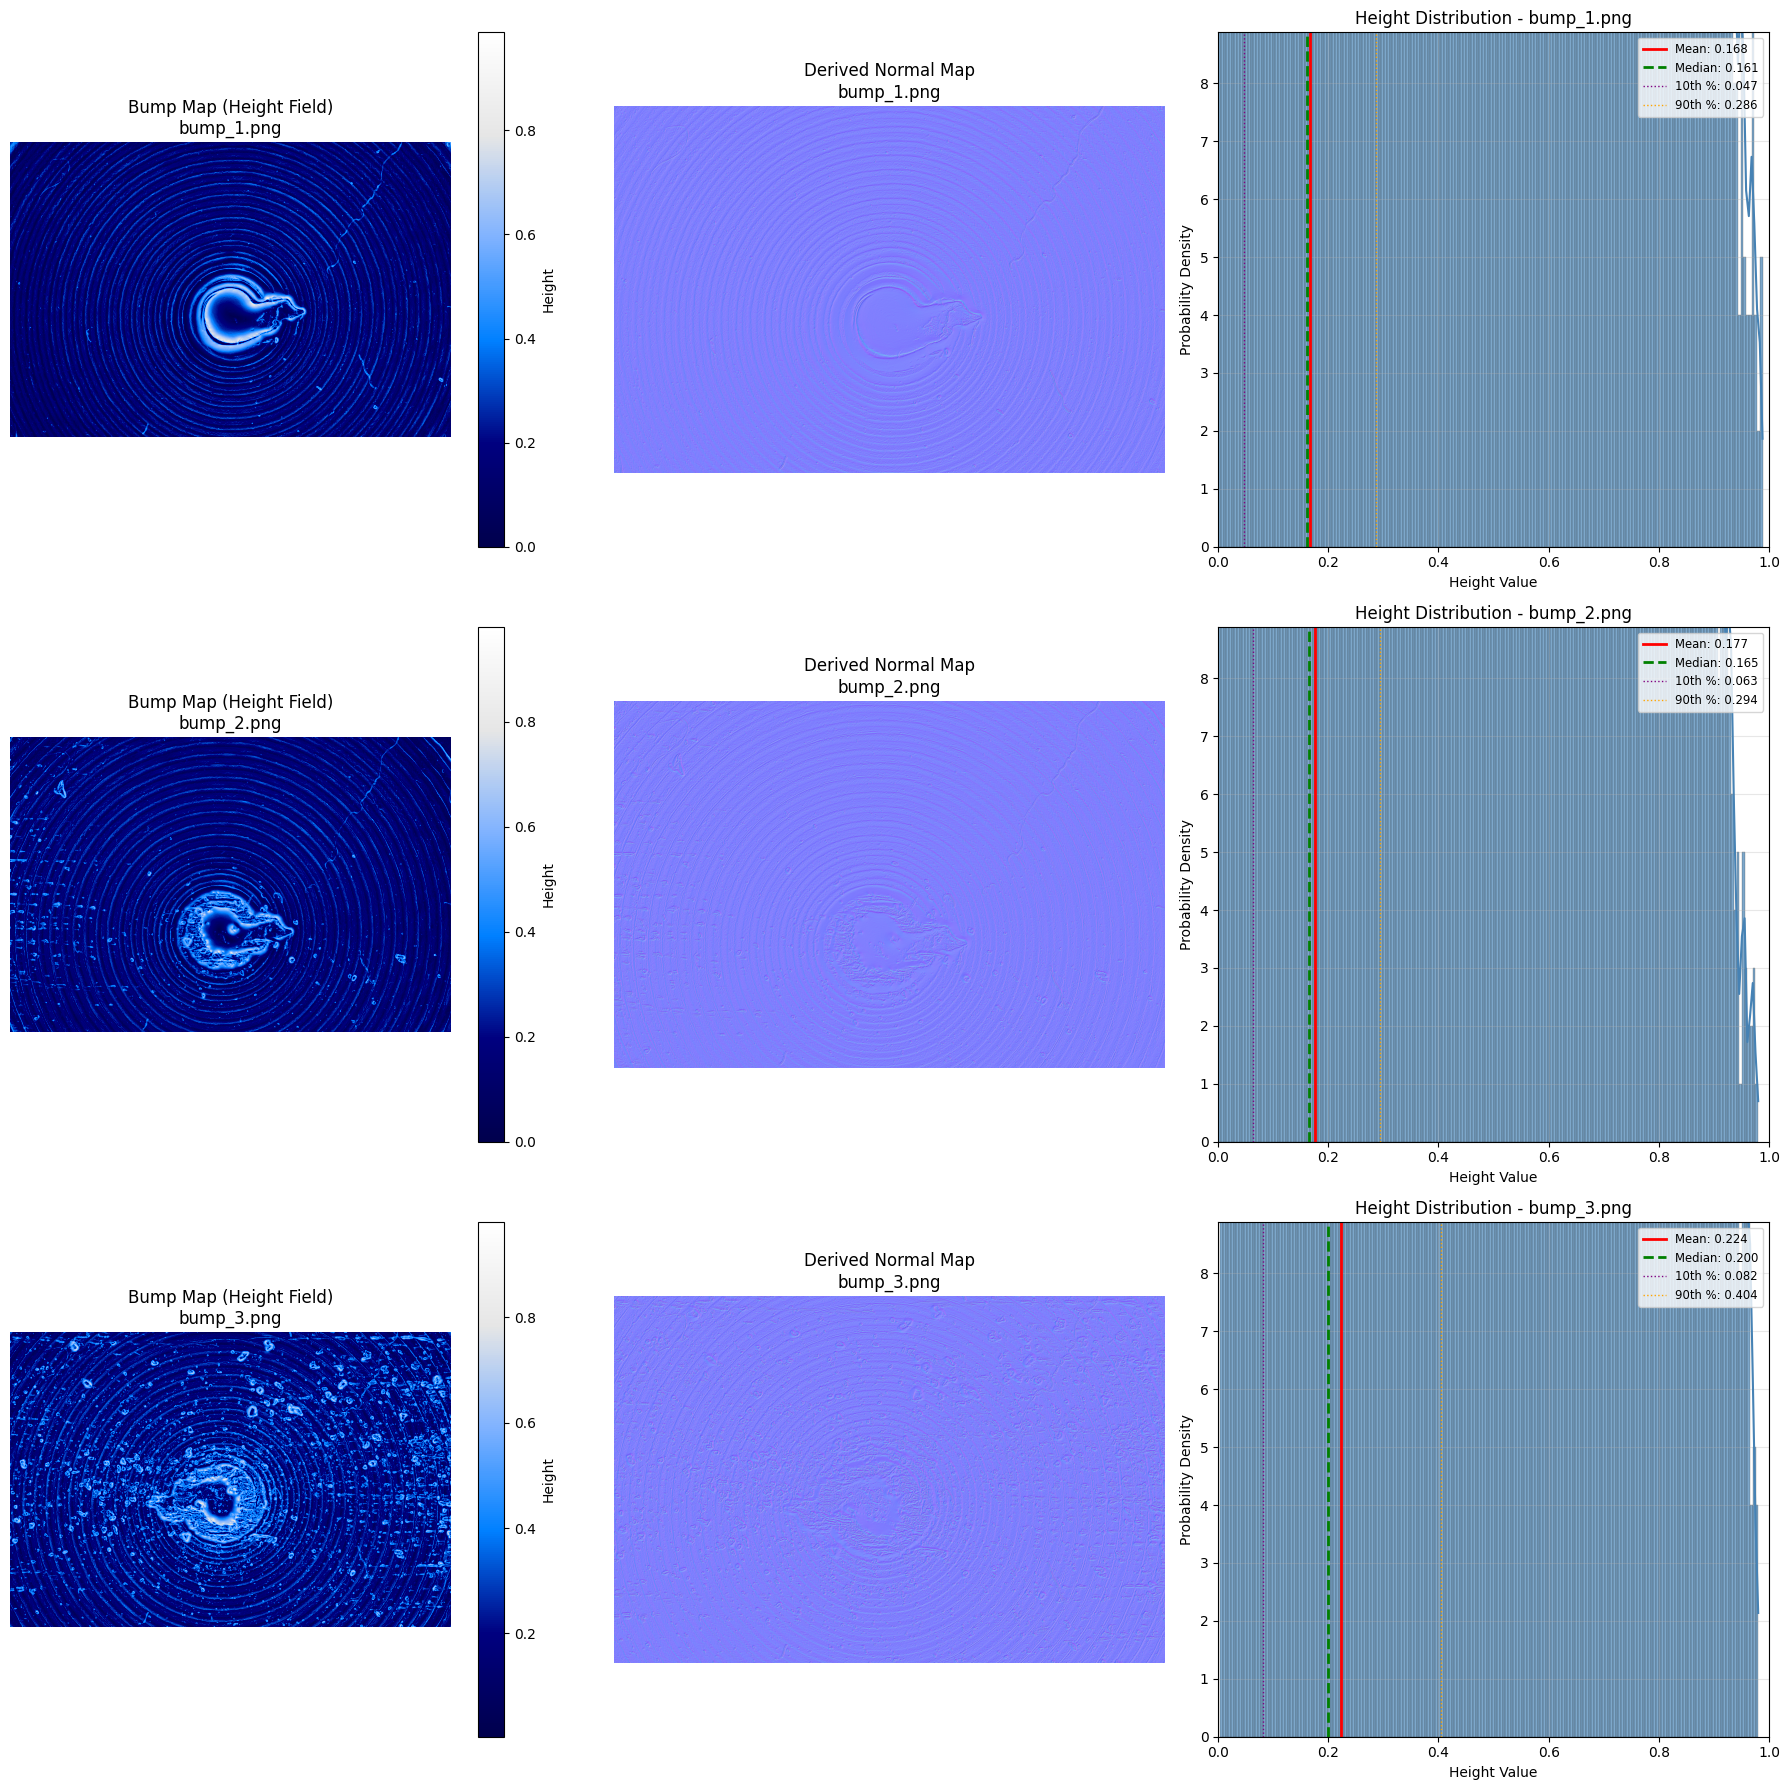

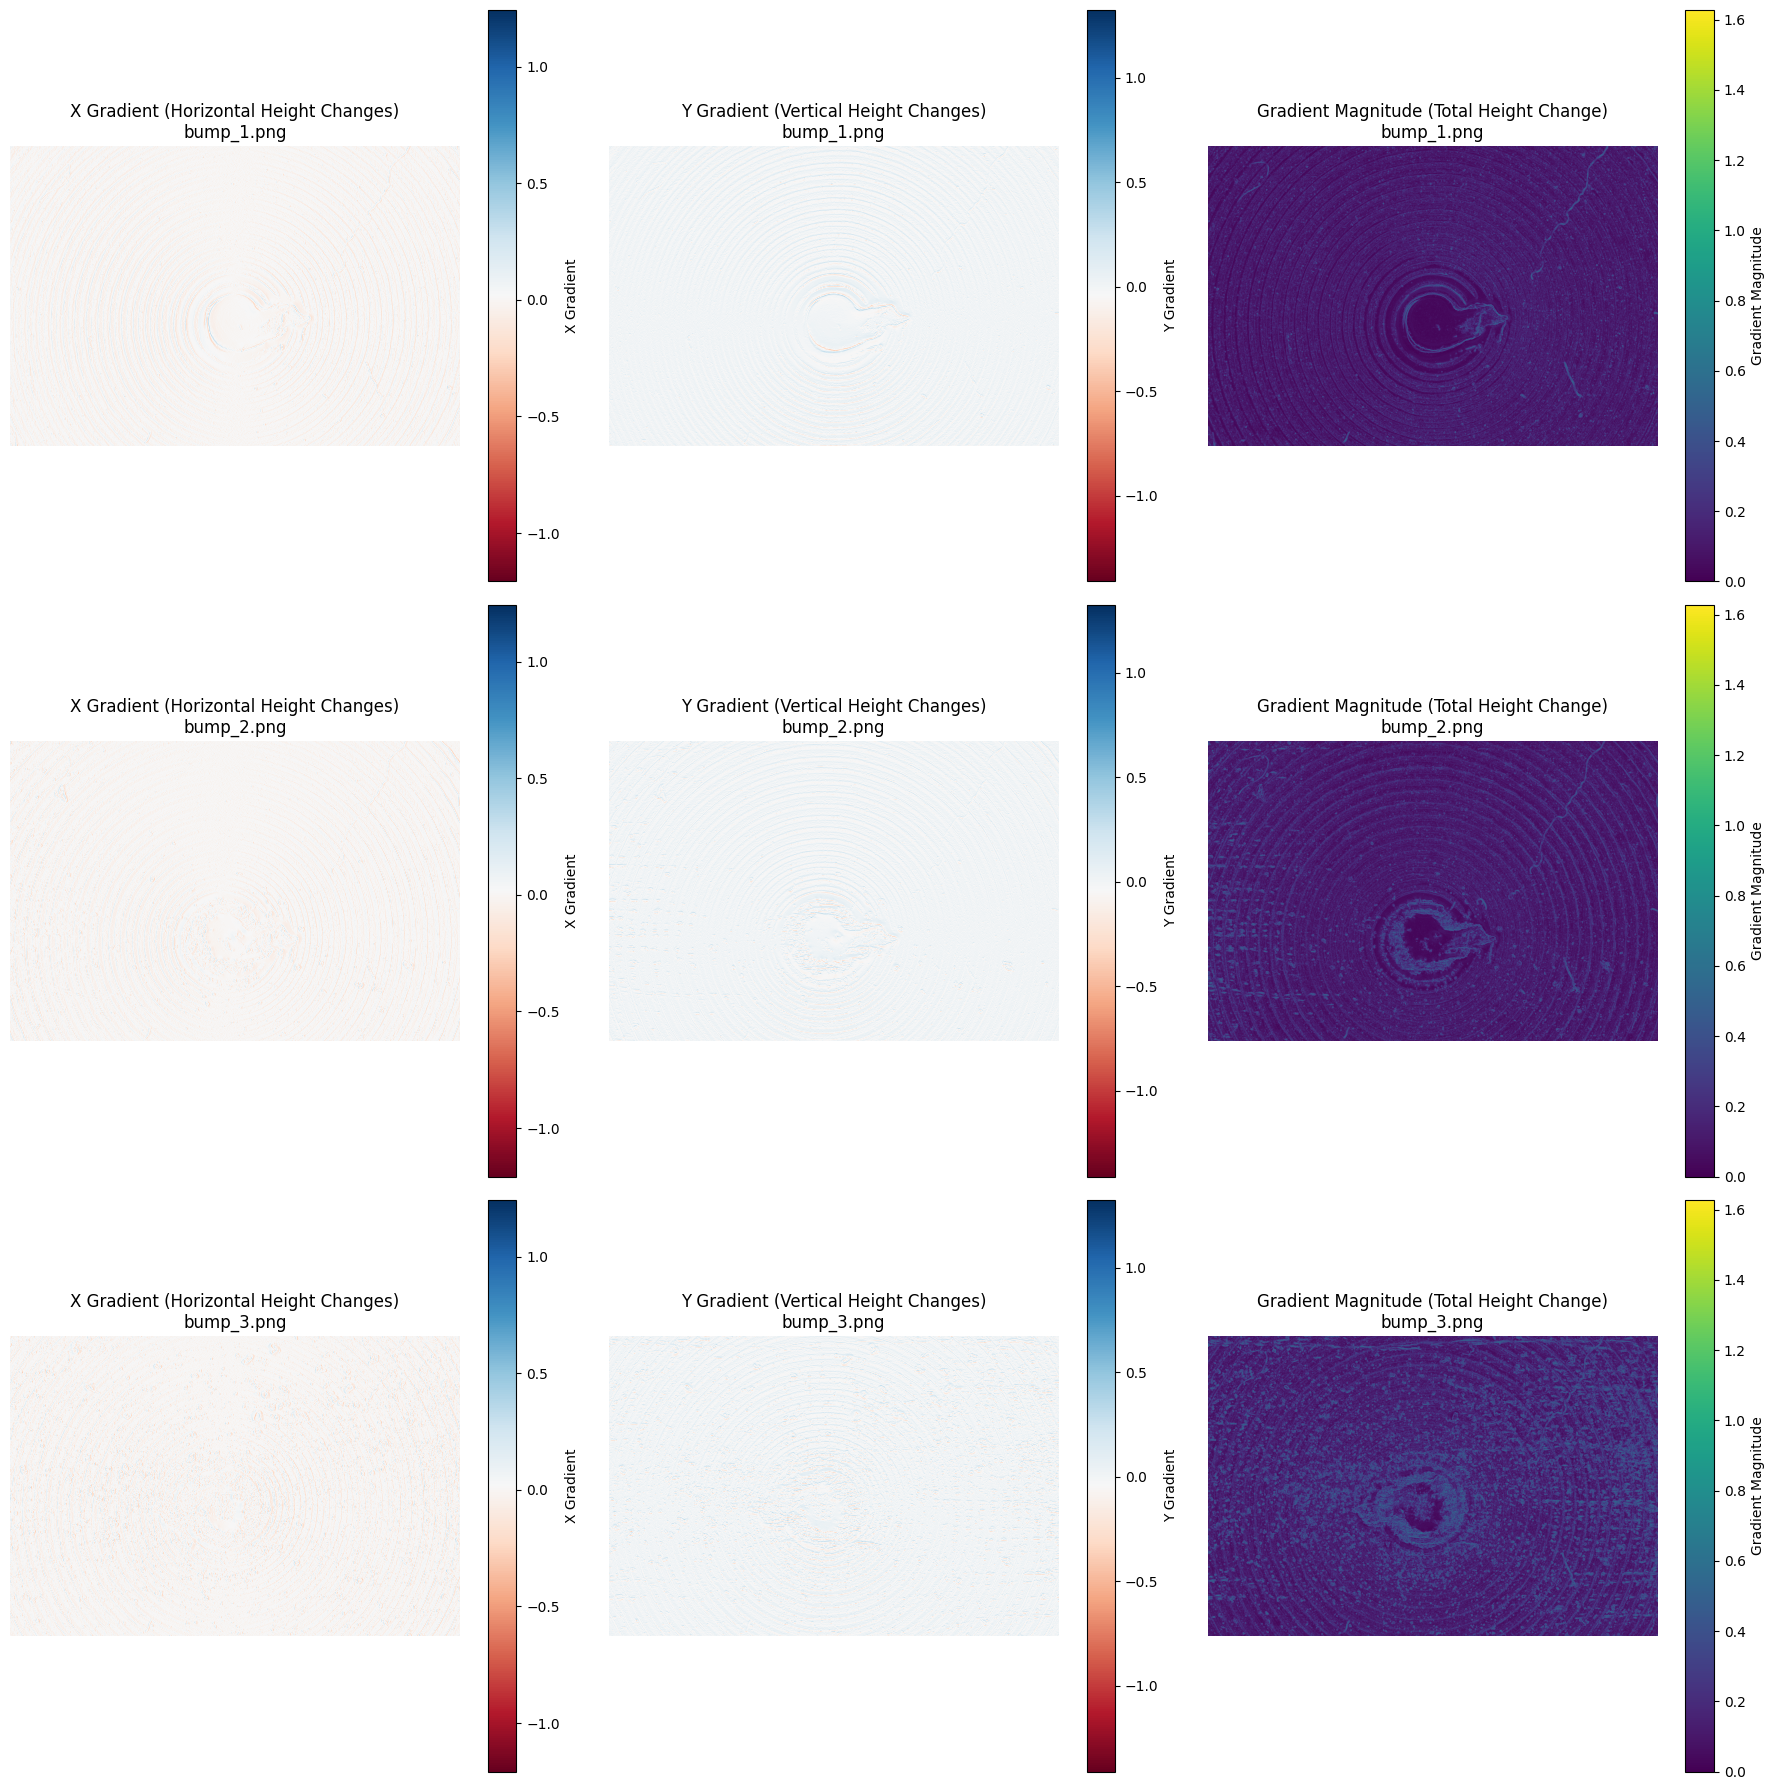

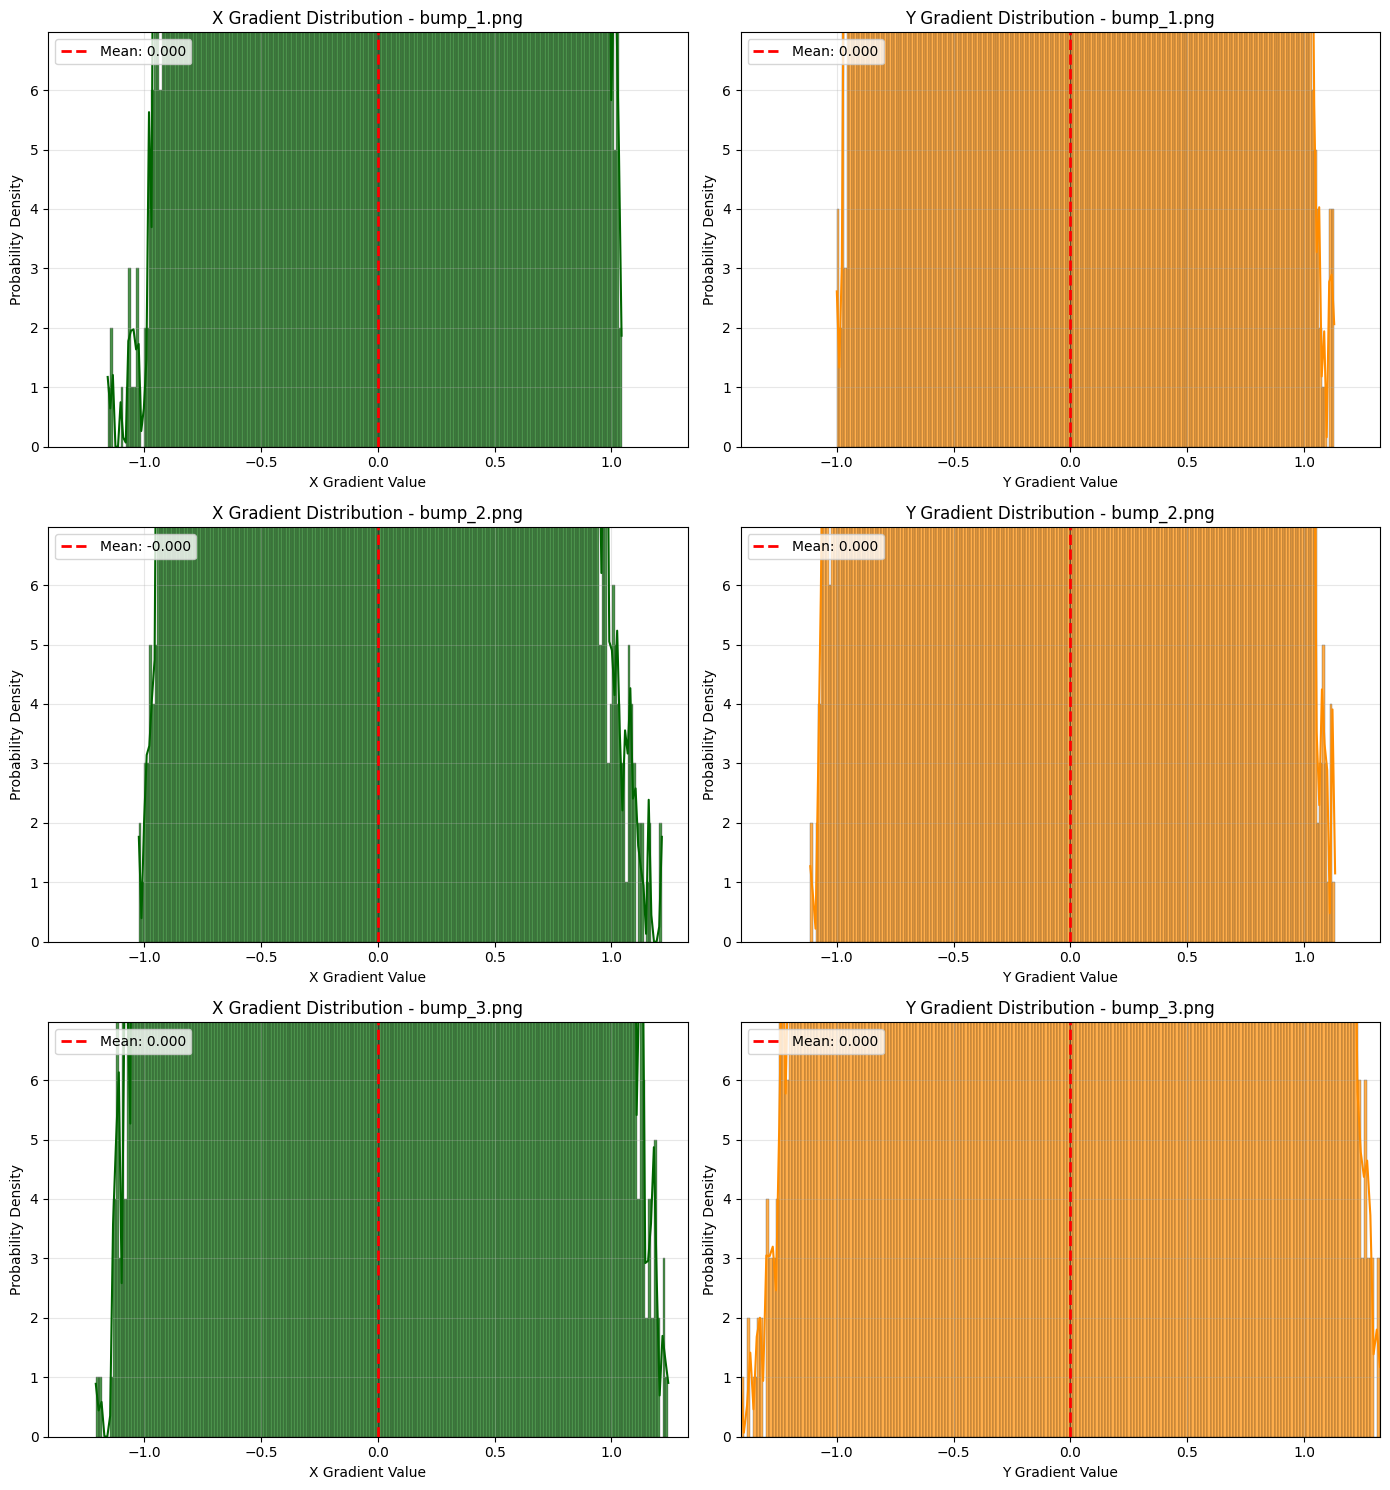

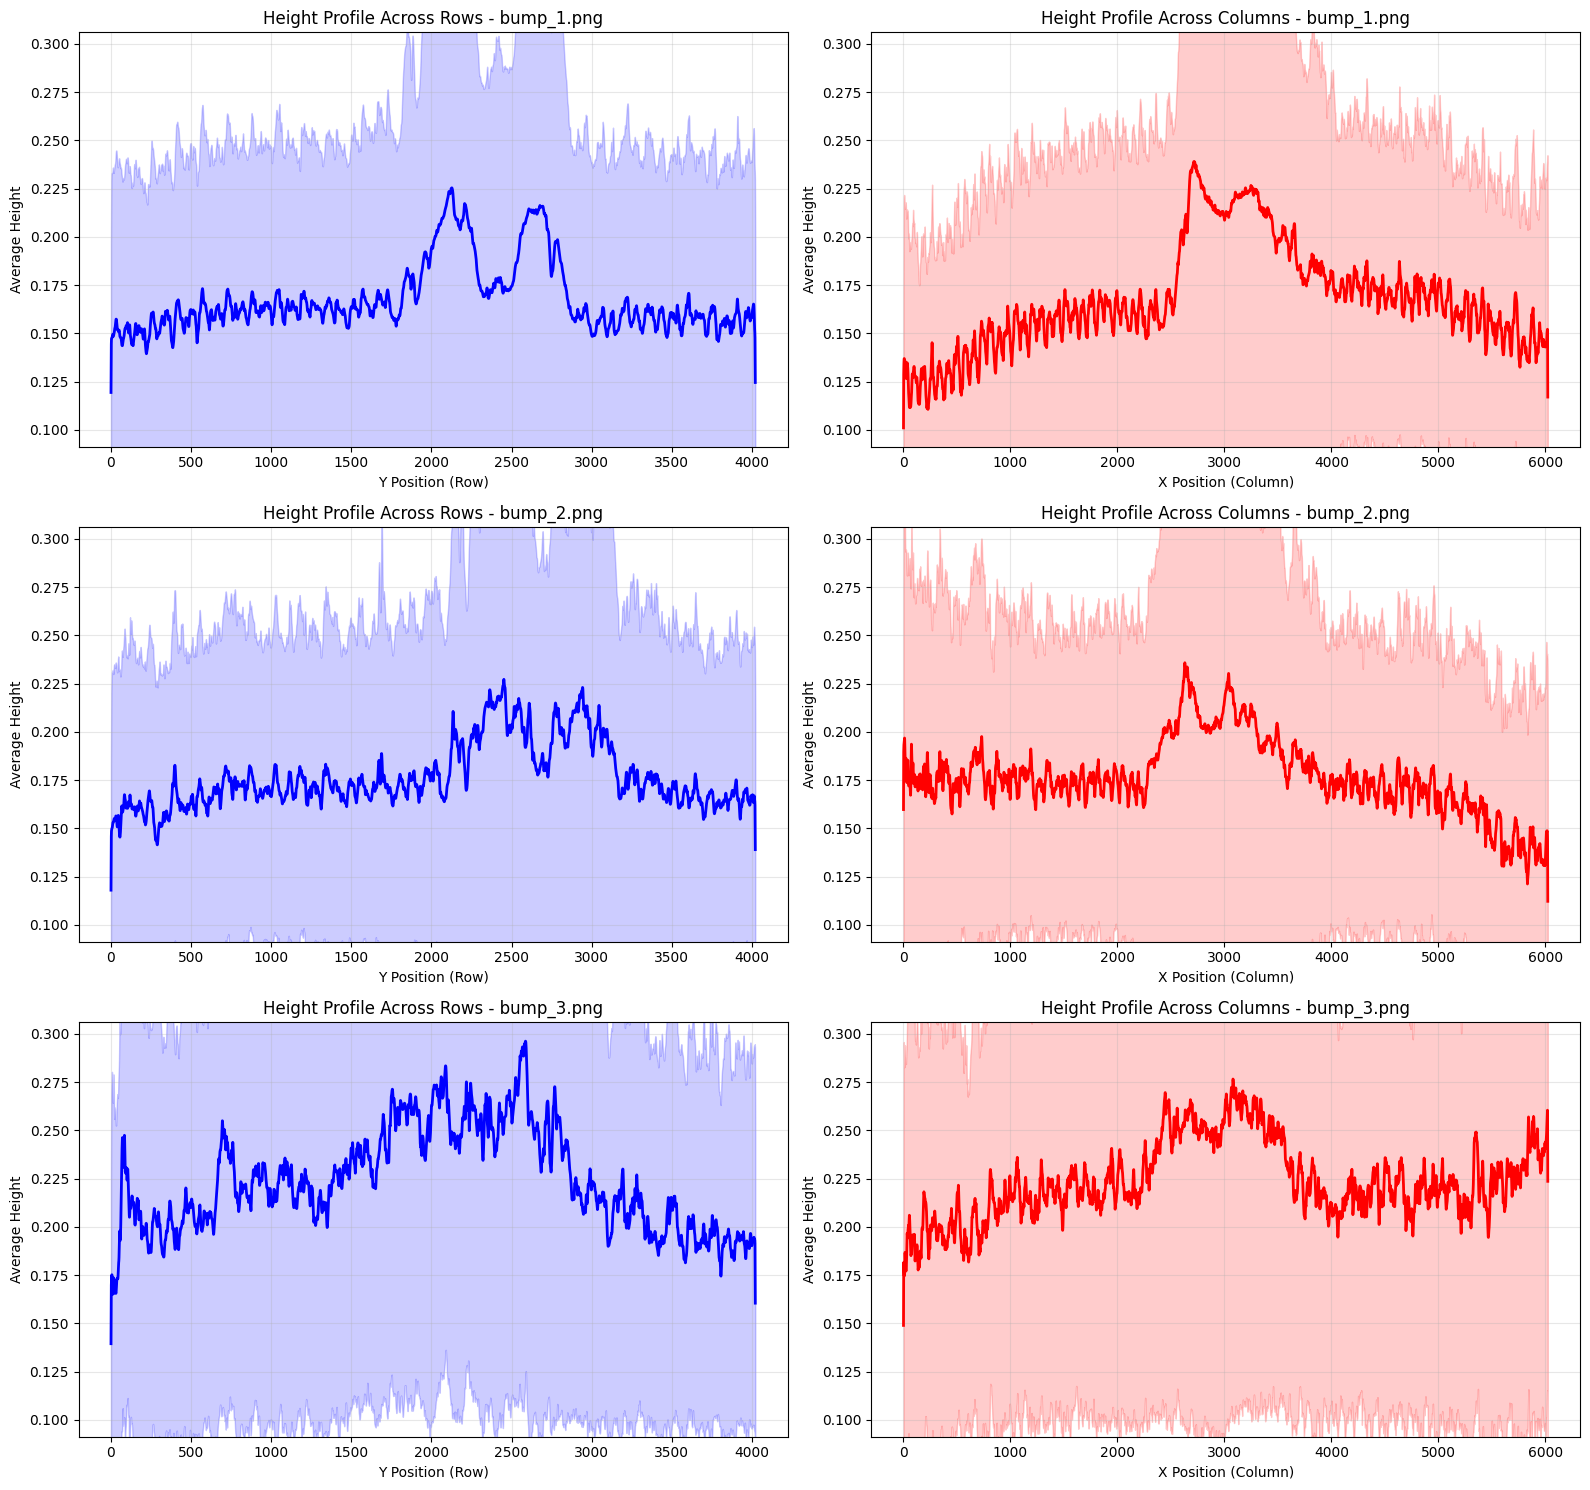

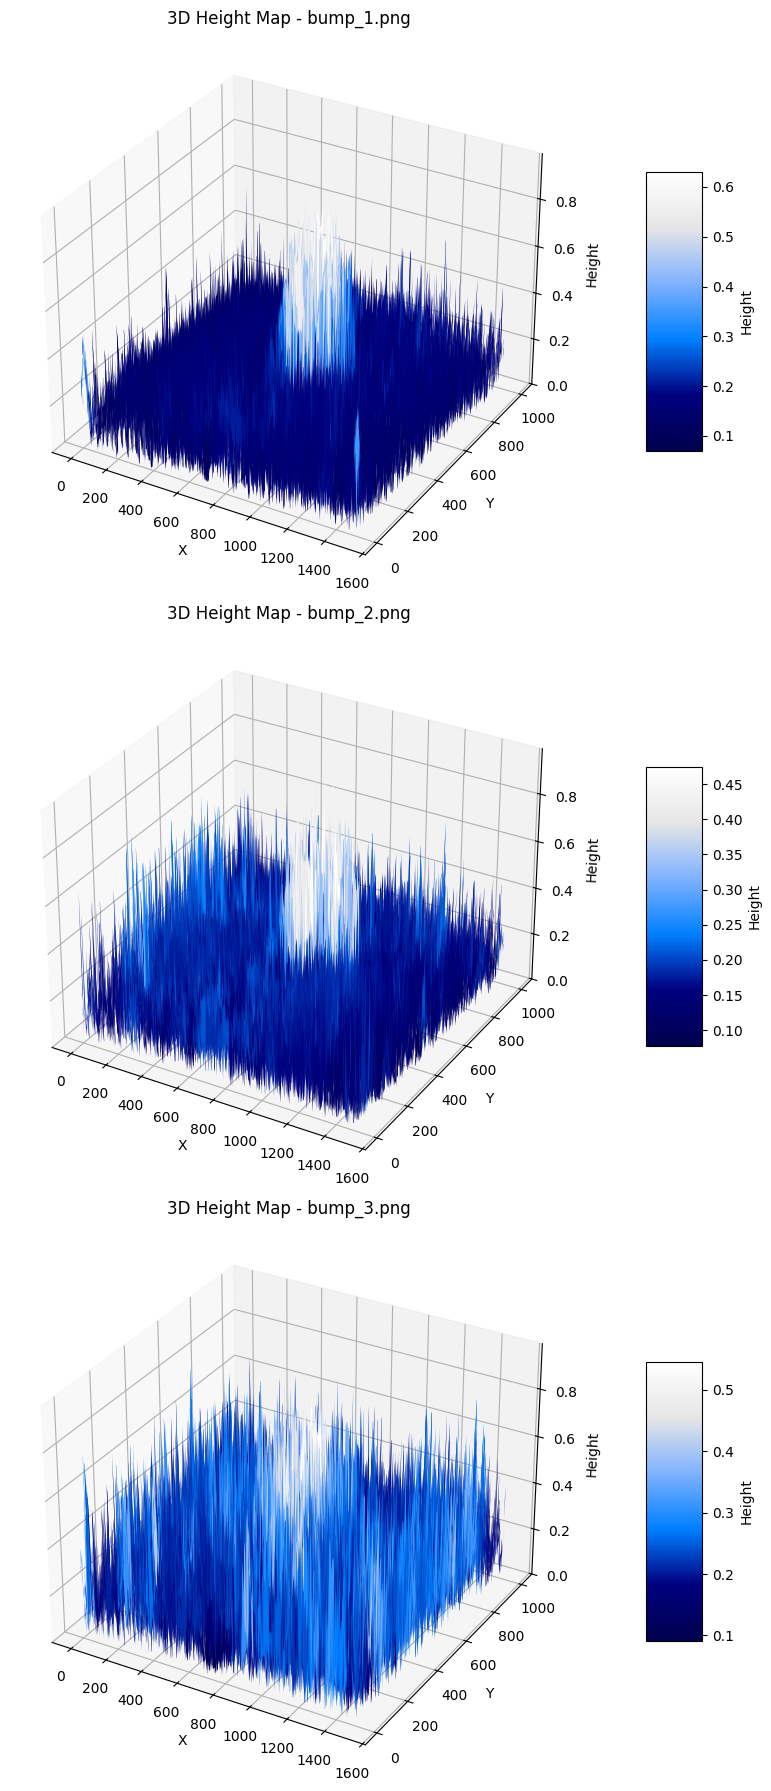

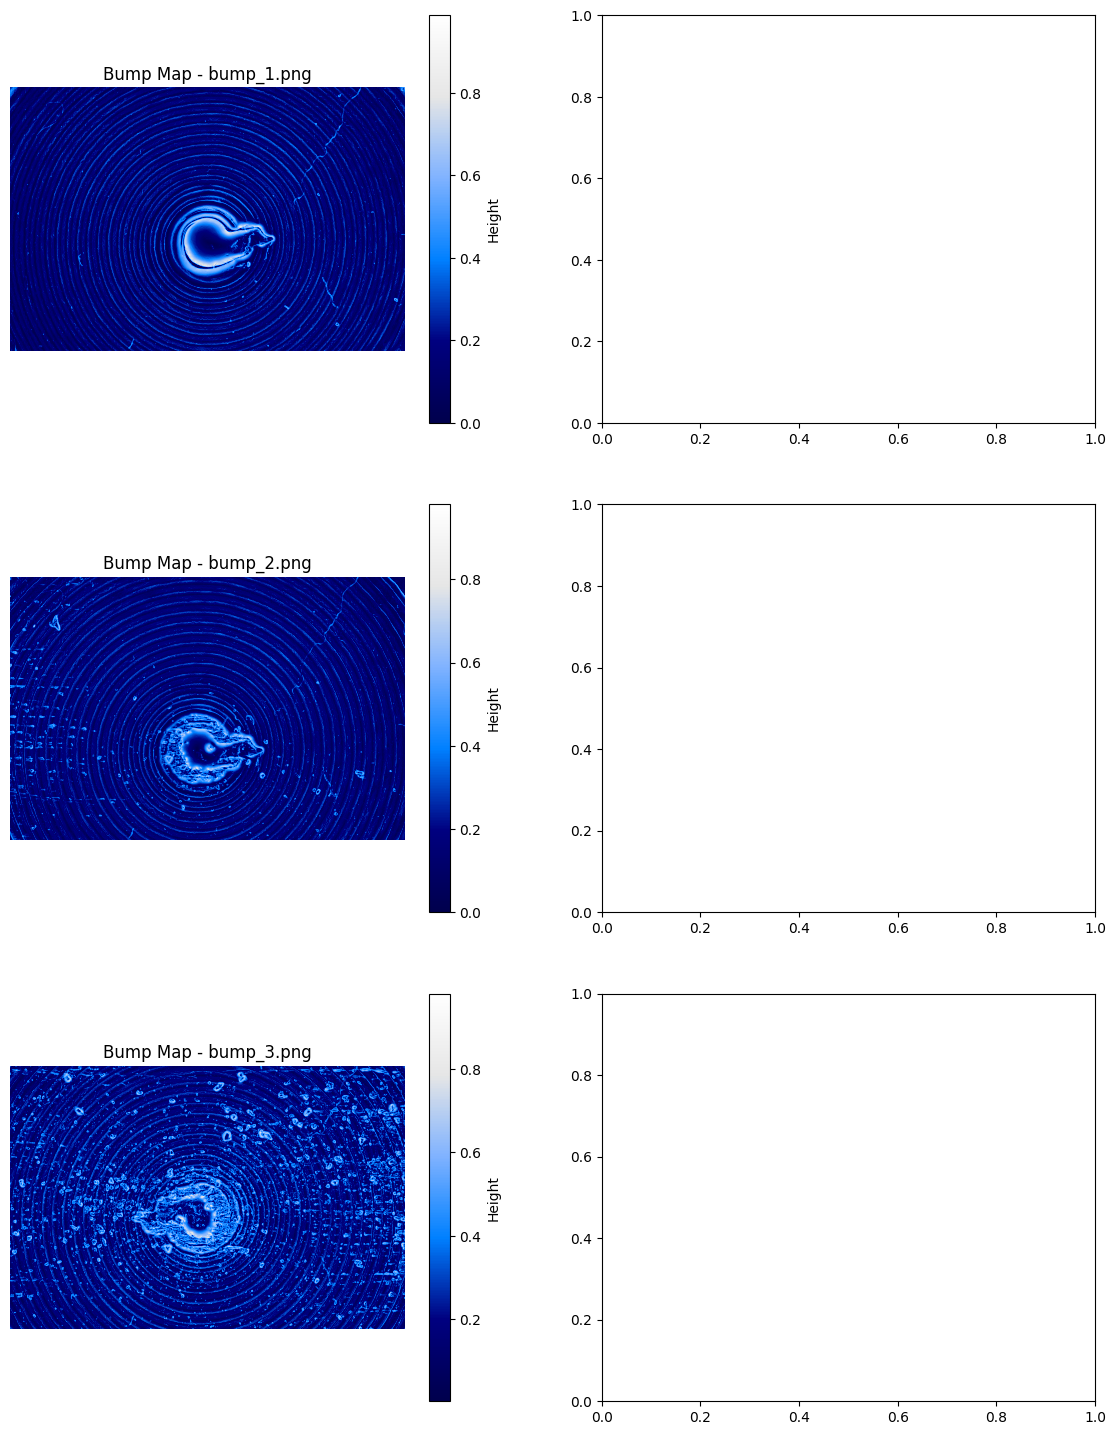

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
from tqdm import tqdm
from scipy import stats, ndimage
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# ============================
# Constants
# ============================
BUMP_FILE_PATTERN = "bump_*.png"  # File pattern to search for
BINS = 200  # Number of bins for histograms
OUTPUT_DIR = "bump_map_analysis_output"  # Directory to save output figures
COLOR_BUMP = 'steelblue'
COLOR_SURFACE_X = 'darkgreen'
COLOR_SURFACE_Y = 'darkorange'

# Create a custom height map colormap (from low/dark to high/bright)
height_colors = [(0, 0, 0.3), (0, 0, 0.5), (0, 0.5, 1), (0.5, 0.7, 1.0), 
                (0.9, 0.9, 0.9), (1, 1, 1)]
height_cmap = LinearSegmentedColormap.from_list('height_cmap', height_colors)

# Create a custom normal map visualization colormap
normal_colors = [(0, 0, 0.5), (0, 0, 1), (0, 1, 1), (1, 1, 1), 
                (1, 1, 0), (1, 0, 0), (0.5, 0, 0)]
normal_cmap = LinearSegmentedColormap.from_list('normal_cmap', normal_colors)

# ============================
# Functions for processing bump maps
# ============================
def load_and_normalize(file_path):
    """Load the image file and normalize pixel values to [0,1]."""
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise IOError(f"Image not found: {file_path}")
        
    # Handle different image types
    if len(img.shape) == 3:  # Color image
        # Convert to grayscale if it's a color image
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bump = img_gray.astype(np.float32) / 255.0
        original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    else:  # Already grayscale
        bump = img.astype(np.float32) / 255.0
        original_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB for display
        
    return original_img, bump

def compute_surface_normals(bump_map, scale=1.0):
    """
    Compute surface normals from the bump map.
    The scale parameter controls the intensity of the effect.
    """
    # Compute gradients using Sobel operators
    grad_x = cv2.Sobel(bump_map, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(bump_map, cv2.CV_32F, 0, 1, ksize=3)
    
    # Scale the gradients to control the intensity
    grad_x = grad_x * scale
    grad_y = grad_y * scale
    
    # Create the normal map
    normal_map = np.zeros((bump_map.shape[0], bump_map.shape[1], 3), dtype=np.float32)
    
    # X component (red channel)
    normal_map[:, :, 0] = -grad_x
    
    # Y component (green channel)
    normal_map[:, :, 1] = -grad_y
    
    # Z component (blue channel) - always positive for a bump map
    normal_map[:, :, 2] = 1.0
    
    # Normalize to unit vectors
    norm = np.sqrt(np.sum(normal_map**2, axis=2))
    norm = np.maximum(norm, 1e-10)  # Avoid division by zero
    normal_map[:, :, 0] /= norm
    normal_map[:, :, 1] /= norm
    normal_map[:, :, 2] /= norm
    
    # Convert from [-1,1] range to [0,1] for visualization
    normal_map_viz = (normal_map + 1.0) / 2.0
    
    return normal_map, normal_map_viz

def compute_height_variations(bump_map):
    """
    Analyze height variations in the bump map.
    Returns various metrics about height changes.
    """
    # Compute gradients (height changes)
    grad_x = cv2.Sobel(bump_map, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(bump_map, cv2.CV_32F, 0, 1, ksize=3)
    
    # Compute gradient magnitude (overall height change)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Calculate various metrics
    variations = {
        'mean_gradient_x': np.mean(np.abs(grad_x)),
        'mean_gradient_y': np.mean(np.abs(grad_y)),
        'mean_gradient_mag': np.mean(gradient_mag),
        'max_gradient_mag': np.max(gradient_mag),
        'std_gradient_mag': np.std(gradient_mag),
        'grad_x': grad_x,
        'grad_y': grad_y,
        'gradient_mag': gradient_mag
    }
    
    return variations

def compute_statistics(bump_map):
    """Compute statistical properties of the bump map."""
    flat_bump = bump_map.flatten()
    
    # Basic statistics
    mean = np.mean(flat_bump)
    median = np.median(flat_bump)
    std = np.std(flat_bump)
    min_val = np.min(flat_bump)
    max_val = np.max(flat_bump)
    
    # Calculate percentiles (10%, 25%, 75%, 90%)
    percentiles = np.percentile(flat_bump, [10, 25, 75, 90])
    
    # Calculate entropy (measure of randomness)
    hist, _ = np.histogram(flat_bump, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)  # Normalize
    non_zero_hist = hist[hist > 0]
    entropy = -np.sum(non_zero_hist * np.log2(non_zero_hist)) if len(non_zero_hist) > 0 else 0
    
    # Calculate height distribution
    height_areas = {
        'low': np.mean(bump_map < 0.25) * 100,      # Low areas (0-0.25)
        'medium_low': np.mean((bump_map >= 0.25) & (bump_map < 0.5)) * 100,  # Medium-low areas (0.25-0.5)
        'medium_high': np.mean((bump_map >= 0.5) & (bump_map < 0.75)) * 100, # Medium-high areas (0.5-0.75)
        'high': np.mean(bump_map >= 0.75) * 100     # High areas (0.75-1.0)
    }
    
    # Add texture metrics
    # Skewness (measure of asymmetry)
    skewness = stats.skew(flat_bump)
    
    # Kurtosis (measure of "tailedness")
    kurtosis = stats.kurtosis(flat_bump)
    
    # Calculate energy (measure of uniformity)
    energy = np.sum(hist**2)
    
    # Calculate local contrast
    local_contrast = np.mean(ndimage.generic_filter(bump_map, np.std, size=5))
    
    stats_dict = {
        'mean': mean,
        'median': median,
        'std': std,
        'min': min_val,
        'max': max_val,
        'range': max_val - min_val,
        'percentiles': percentiles,
        'entropy': entropy,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'energy': energy,
        'local_contrast': local_contrast,
        'height_areas': height_areas
    }
    
    return stats_dict

def compute_displacement_profile(bump_map):
    """Compute a profile of height displacement across rows and columns."""
    # Calculate average height for each row and column
    row_profile = np.mean(bump_map, axis=1)
    col_profile = np.mean(bump_map, axis=0)
    
    # Calculate the height variance for each row and column
    row_variance = np.var(bump_map, axis=1)
    col_variance = np.var(bump_map, axis=0)
    
    return {
        'row_profile': row_profile,
        'col_profile': col_profile,
        'row_variance': row_variance,
        'col_variance': col_variance
    }

def compute_frequency_analysis(bump_map):
    """Compute Fourier transform to analyze frequency components."""
    # Apply FFT
    f_transform = np.fft.fft2(bump_map)
    f_shift = np.fft.fftshift(f_transform)
    
    # Calculate the magnitude spectrum (log scale for better visualization)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    
    # Normalize for display
    if np.max(magnitude_spectrum) > 0:
        normalized_spectrum = magnitude_spectrum / np.max(magnitude_spectrum)
    else:
        normalized_spectrum = magnitude_spectrum
        
    return normalized_spectrum

def create_height_map_3d(bump_map, downsample_factor=4):
    """
    Create data for a 3D visualization of the height map.
    Downsamples the map for better performance.
    """
    # Downsample the bump map for performance
    h, w = bump_map.shape
    ds_h, ds_w = h // downsample_factor, w // downsample_factor
    downsampled = cv2.resize(bump_map, (ds_w, ds_h))
    
    # Create a meshgrid for the 3D plot
    x = np.arange(0, ds_w, 1)
    y = np.arange(0, ds_h, 1)
    X, Y = np.meshgrid(x, y)
    
    # Z values are the height from the bump map
    Z = downsampled
    
    return X, Y, Z

def process_bump_map(file_path, scale=1.0):
    """Process a single bump map file."""
    # Load and normalize the image
    original_img, bump_map = load_and_normalize(file_path)
    
    # Compute surface normals
    normal_map, normal_map_viz = compute_surface_normals(bump_map, scale)
    
    # Compute height variations
    variations = compute_height_variations(bump_map)
    
    # Compute statistics
    stats = compute_statistics(bump_map)
    
    # Compute displacement profiles
    profiles = compute_displacement_profile(bump_map)
    
    # Compute frequency analysis
    frequency_spectrum = compute_frequency_analysis(bump_map)
    
    # Prepare 3D visualization data
    X, Y, Z = create_height_map_3d(bump_map)
    
    # Create a result dictionary with all the data
    result = {
        'file_path': file_path,
        'original_img': original_img,
        'bump_map': bump_map,
        'normal_map': normal_map,
        'normal_map_viz': normal_map_viz,
        'variations': variations,
        'profiles': profiles,
        'frequency_spectrum': frequency_spectrum,
        '3d_data': (X, Y, Z),
        'stats': stats
    }
    
    return result

# ============================
# Functions for plotting
# ============================
def get_global_min_max_y(results, hist_type):
    """Determine global y-axis limits for histograms to ensure consistent scales."""
    max_density = 0
    
    if hist_type == 'bump':
        for result in results:
            hist, _ = np.histogram(result['bump_map'].flatten(), bins=BINS, density=True)
            max_density = max(max_density, np.max(hist))
    elif hist_type == 'gradient':
        for result in results:
            for gradient in [result['variations']['grad_x'], result['variations']['grad_y']]:
                hist, _ = np.histogram(gradient.flatten(), bins=BINS, density=True)
                max_density = max(max_density, np.max(hist))
    
    # Add a small buffer (15%) to the max value for better visualization
    max_density *= 1.15
    
    return (0, max_density)

def plot_bump_maps_with_normals(results):
    """Plot each bump map with its normal map and height histogram."""
    n_images = len(results)
    fig, axs = plt.subplots(n_images, 3, figsize=(18, 6 * n_images))
    if n_images == 1:
        axs = np.expand_dims(axs, axis=0)
        
    # Get global y-axis limits for bump histograms
    bump_ylim = get_global_min_max_y(results, 'bump')
    
    # Calculate max dimensions to ensure consistent zoom levels
    all_heights = []
    all_widths = []
    for result in results:
        h, w = result['bump_map'].shape
        all_heights.append(h)
        all_widths.append(w)
    
    max_height = max(all_heights)
    max_width = max(all_widths)
    
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        stats = result['stats']
        
        # Display the bump map with height colormap
        ax_bump = axs[idx, 0]
        im = ax_bump.imshow(result['bump_map'], cmap=height_cmap)
        ax_bump.set_title(f"Bump Map (Height Field)\n{filename}")
        
        # Ensure consistent zoom level across all images
        h, w = result['bump_map'].shape
        x_center = w / 2
        y_center = h / 2
        ax_bump.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_bump.set_ylim(y_center + max_height/2, y_center - max_height/2)
        
        ax_bump.set_aspect('equal')
        ax_bump.axis("off")
        plt.colorbar(im, ax=ax_bump, orientation='vertical', label='Height')
        
        # Display the normal map visualization
        ax_normal = axs[idx, 1]
        ax_normal.imshow(result['normal_map_viz'])
        ax_normal.set_title(f"Derived Normal Map\n{filename}")
        
        # Ensure consistent zoom level for normal maps too
        ax_normal.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_normal.set_ylim(y_center + max_height/2, y_center - max_height/2)
        
        ax_normal.set_aspect('equal')
        ax_normal.axis("off")
        
        # Bump map histogram
        ax_hist = axs[idx, 2]
        sns.histplot(result['bump_map'].flatten(), bins=BINS, kde=True, 
                    color=COLOR_BUMP, edgecolor='black', alpha=0.7, ax=ax_hist)
        ax_hist.set_xlabel("Height Value")
        ax_hist.set_ylabel("Probability Density")
        ax_hist.set_title(f"Height Distribution - {filename}")
        ax_hist.set_xlim(0, 1)
        ax_hist.set_ylim(*bump_ylim)
        ax_hist.grid(True, alpha=0.3)
        
        # Add mean and median lines
        ax_hist.axvline(stats['mean'], color='red', linestyle='-', linewidth=2, 
                      label=f'Mean: {stats["mean"]:.3f}')
        ax_hist.axvline(stats['median'], color='green', linestyle='--', linewidth=2, 
                      label=f'Median: {stats["median"]:.3f}')
        
        # Add percentile lines
        ax_hist.axvline(stats['percentiles'][0], color='purple', linestyle=':', linewidth=1,
                      label=f'10th %: {stats["percentiles"][0]:.3f}')
        ax_hist.axvline(stats['percentiles'][3], color='orange', linestyle=':', linewidth=1,
                      label=f'90th %: {stats["percentiles"][3]:.3f}')
        
        ax_hist.legend(loc='upper right', fontsize='small')
        
    plt.tight_layout()
    return fig

def plot_height_variations(results):
    """Plot gradient visualizations for each bump map."""
    n_images = len(results)
    fig, axs = plt.subplots(n_images, 3, figsize=(18, 6 * n_images))
    if n_images == 1:
        axs = np.expand_dims(axs, axis=0)
        
    # Calculate max dimensions to ensure consistent zoom levels
    all_heights = []
    all_widths = []
    for result in results:
        h, w = result['bump_map'].shape
        all_heights.append(h)
        all_widths.append(w)
    
    max_height = max(all_heights)
    max_width = max(all_widths)
    
    # Global color scale for gradients
    all_grad_x = np.concatenate([result['variations']['grad_x'].flatten() for result in results])
    all_grad_y = np.concatenate([result['variations']['grad_y'].flatten() for result in results])
    all_grad_mag = np.concatenate([result['variations']['gradient_mag'].flatten() for result in results])
    
    vmin_x, vmax_x = np.min(all_grad_x), np.max(all_grad_x)
    vmin_y, vmax_y = np.min(all_grad_y), np.max(all_grad_y)
    vmin_mag, vmax_mag = 0, np.max(all_grad_mag)  # Magnitude is always positive
    
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        variations = result['variations']
        
        # X gradient (horizontal height changes)
        ax_x = axs[idx, 0]
        im_x = ax_x.imshow(variations['grad_x'], cmap='RdBu', vmin=vmin_x, vmax=vmax_x)
        ax_x.set_title(f"X Gradient (Horizontal Height Changes)\n{filename}")
        
        # Ensure consistent zoom level
        h, w = result['bump_map'].shape
        x_center = w / 2
        y_center = h / 2
        ax_x.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_x.set_ylim(y_center + max_height/2, y_center - max_height/2)
        
        ax_x.set_aspect('equal')
        ax_x.axis("off")
        plt.colorbar(im_x, ax=ax_x, orientation='vertical', label='X Gradient')
        
        # Y gradient (vertical height changes)
        ax_y = axs[idx, 1]
        im_y = ax_y.imshow(variations['grad_y'], cmap='RdBu', vmin=vmin_y, vmax=vmax_y)
        ax_y.set_title(f"Y Gradient (Vertical Height Changes)\n{filename}")
        
        # Ensure consistent zoom level
        ax_y.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_y.set_ylim(y_center + max_height/2, y_center - max_height/2)
        
        ax_y.set_aspect('equal')
        ax_y.axis("off")
        plt.colorbar(im_y, ax=ax_y, orientation='vertical', label='Y Gradient')
        
        # Gradient magnitude (overall height changes)
        ax_mag = axs[idx, 2]
        im_mag = ax_mag.imshow(variations['gradient_mag'], cmap='viridis', vmin=vmin_mag, vmax=vmax_mag)
        ax_mag.set_title(f"Gradient Magnitude (Total Height Change)\n{filename}")
        
        # Ensure consistent zoom level
        ax_mag.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_mag.set_ylim(y_center + max_height/2, y_center - max_height/2)
        
        ax_mag.set_aspect('equal')
        ax_mag.axis("off")
        plt.colorbar(im_mag, ax=ax_mag, orientation='vertical', label='Gradient Magnitude')
        
    plt.tight_layout()
    return fig

def plot_gradient_histograms(results):
    """Plot histograms of the x and y gradients for each bump map."""
    n_images = len(results)
    fig, axs = plt.subplots(n_images, 2, figsize=(14, 5 * n_images))
    if n_images == 1:
        axs = np.expand_dims(axs, axis=0)
        
    # Get global y-axis limits for gradient histograms
    gradient_ylim = get_global_min_max_y(results, 'gradient')
    
    # Find global x limits for consistent display
    all_grad_x = np.concatenate([result['variations']['grad_x'].flatten() for result in results])
    all_grad_y = np.concatenate([result['variations']['grad_y'].flatten() for result in results])
    
    x_min = min(np.min(all_grad_x), np.min(all_grad_y))
    x_max = max(np.max(all_grad_x), np.max(all_grad_y))
    x_lim = (x_min, x_max)
    
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        variations = result['variations']
        
        # X gradient histogram
        ax_x = axs[idx, 0]
        sns.histplot(variations['grad_x'].flatten(), bins=BINS, kde=True,
                   color=COLOR_SURFACE_X, edgecolor='black', alpha=0.7, ax=ax_x)
        ax_x.set_xlabel("X Gradient Value")
        ax_x.set_ylabel("Probability Density")
        ax_x.set_title(f"X Gradient Distribution - {filename}")
        ax_x.set_xlim(*x_lim)
        ax_x.set_ylim(*gradient_ylim)
        ax_x.grid(True, alpha=0.3)
        
        # Add vertical line at zero
        ax_x.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        # Add mean line
        mean_x = np.mean(variations['grad_x'])
        ax_x.axvline(mean_x, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_x:.3f}')
        ax_x.legend()
        
        # Y gradient histogram
        ax_y = axs[idx, 1]
        sns.histplot(variations['grad_y'].flatten(), bins=BINS, kde=True,
                   color=COLOR_SURFACE_Y, edgecolor='black', alpha=0.7, ax=ax_y)
        ax_y.set_xlabel("Y Gradient Value")
        ax_y.set_ylabel("Probability Density")
        ax_y.set_title(f"Y Gradient Distribution - {filename}")
        ax_y.set_xlim(*x_lim)
        ax_y.set_ylim(*gradient_ylim)
        ax_y.grid(True, alpha=0.3)
        
        # Add vertical line at zero
        ax_y.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        # Add mean line
        mean_y = np.mean(variations['grad_y'])
        ax_y.axvline(mean_y, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_y:.3f}')
        ax_y.legend()
        
    plt.tight_layout()
    return fig

def plot_displacement_profiles(results):
    """Plot height displacement profiles for each bump map."""
    n_images = len(results)
    fig, axs = plt.subplots(n_images, 2, figsize=(16, 5 * n_images))
    if n_images == 1:
        axs = np.expand_dims(axs, axis=0)
    
    # Find global y limits for consistent display
    all_row_profiles = np.concatenate([result['profiles']['row_profile'] for result in results])
    all_col_profiles = np.concatenate([result['profiles']['col_profile'] for result in results])
    
    y_min = min(np.min(all_row_profiles), np.min(all_col_profiles))
    y_max = max(np.max(all_row_profiles), np.max(all_col_profiles))
    
    # Add some padding
    y_range = y_max - y_min
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    y_lim = (y_min, y_max)
    
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        profiles = result['profiles']
        
        # Row profile (height across rows)
        ax_row = axs[idx, 0]
        ax_row.plot(np.arange(len(profiles['row_profile'])), profiles['row_profile'], 
                  'b-', linewidth=2)
        ax_row.fill_between(np.arange(len(profiles['row_profile'])), 
                          profiles['row_profile'] - np.sqrt(profiles['row_variance']),
                          profiles['row_profile'] + np.sqrt(profiles['row_variance']),
                          color='blue', alpha=0.2)
        ax_row.set_xlabel("Y Position (Row)")
        ax_row.set_ylabel("Average Height")
        ax_row.set_title(f"Height Profile Across Rows - {filename}")
        ax_row.set_ylim(*y_lim)
        ax_row.grid(True, alpha=0.3)
        
        # Column profile (height across columns)
        ax_col = axs[idx, 1]
        ax_col.plot(np.arange(len(profiles['col_profile'])), profiles['col_profile'], 
                  'r-', linewidth=2)
        ax_col.fill_between(np.arange(len(profiles['col_profile'])), 
                          profiles['col_profile'] - np.sqrt(profiles['col_variance']),
                          profiles['col_profile'] + np.sqrt(profiles['col_variance']),
                          color='red', alpha=0.2)
        ax_col.set_xlabel("X Position (Column)")
        ax_col.set_ylabel("Average Height")
        ax_col.set_title(f"Height Profile Across Columns - {filename}")
        ax_col.set_ylim(*y_lim)
        ax_col.grid(True, alpha=0.3)
        
    plt.tight_layout()
    return fig

def plot_3d_height_maps(results):
    """Create 3D visualizations of each height map."""
    n_images = len(results)
    fig = plt.figure(figsize=(16, 6 * n_images))
    
    # Find global z limits for consistent display
    z_min = min(np.min(result['bump_map']) for result in results)
    z_max = max(np.max(result['bump_map']) for result in results)
    
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        X, Y, Z = result['3d_data']
        
        # Create a 3D subplot
        ax = fig.add_subplot(n_images, 1, idx + 1, projection='3d')
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, cmap=height_cmap, 
                              linewidth=0, antialiased=True)
        
        # Set the z limits for consistent scale
        ax.set_zlim(z_min, z_max)
        
        # Set title and labels
        ax.set_title(f"3D Height Map - {filename}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Height")
        
        # Add a color bar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Height')
        
    plt.tight_layout()
    return fig

def plot_frequency_analysis(results):
    """Plot frequency domain visualization for each bump map."""
    n_images = len(results)
    fig, axs = plt.subplots(n_images, 2, figsize=(14, 6 * n_images))
    if n_images == 1:
        axs = np.expand_dims(axs, axis=0)
    
    # Calculate max dimensions for consistent zoom
    all_heights = []
    all_widths = []
    for result in results:
        h, w = result['frequency_spectrum'].shape
        all_heights.append(h)
        all_widths.append(w)
    
    max_height = max(all_heights)
    max_width = max(all_widths)
        
    for idx, result in enumerate(results):
        filename = os.path.basename(result['file_path'])
        
        # Original bump map
        ax_orig = axs[idx, 0]
        im_orig = ax_orig.imshow(result['bump_map'], cmap=height_cmap)
        ax_orig.set_title(f"Bump Map - {filename}")
        
        # Ensure consistent zoom
        h, w = result['bump_map'].shape
        x_center = w / 2
        y_center = h / 2
        ax_orig.set_xlim(x_center - max_width/2, x_center + max_width/2)
        ax_orig.set_ylim(y_center + max_height/2, y_center - max_height/2)

        ax_orig.set_aspect('equal')
        ax_orig.axis("off")
        plt.colorbar(im_orig, ax=ax_orig, orientation='vertical', label='Height')

def main():
    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load all bump maps
    bump_files = glob.glob(BUMP_FILE_PATTERN)
    bump_files.sort()  # Sort files for consistent ordering
    
    results = []
    
    # Process each bump map file
    for file_path in tqdm(bump_files, desc="Processing Bump Maps"):
        result = process_bump_map(file_path, scale=1.0)
        results.append(result)
    
    # Plot and save figures
    bump_fig = plot_bump_maps_with_normals(results)
    bump_fig.savefig(os.path.join(OUTPUT_DIR, "bump_maps_with_normals.png"))
    
    height_variations_fig = plot_height_variations(results)
    height_variations_fig.savefig(os.path.join(OUTPUT_DIR, "height_variations.png"))
    
    gradient_histograms_fig = plot_gradient_histograms(results)
    gradient_histograms_fig.savefig(os.path.join(OUTPUT_DIR, "gradient_histograms.png"))
    
    displacement_profiles_fig = plot_displacement_profiles(results)
    displacement_profiles_fig.savefig(os.path.join(OUTPUT_DIR, "displacement_profiles.png"))
    
    height_maps_3d_fig = plot_3d_height_maps(results)
    height_maps_3d_fig.savefig(os.path.join(OUTPUT_DIR, "3d_height_maps.png"))
    
    frequency_analysis_fig = plot_frequency_analysis(results)
    frequency_analysis_fig.savefig(os.path.join(OUTPUT_DIR, "frequency_analysis.png"))
    
    plt.show()
    print(f"All figures saved in '{OUTPUT_DIR}' directory.")

if __name__ == "__main__":
    main()